In [19]:
import pandas as pd
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, Ridge, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn import metrics

import matplotlib.pyplot as plt
import altair as alt


In [3]:
ift_data = pd.read_excel('data/ift_data.xlsx')

In [5]:
# let's explore the data
ift_data.head()

,Gas,Water_content,time_minutes,volume_ratio,IFT
0,CH4,0.0,0.000050,1.000000,25.08
1,CH4,0.0,14.998333,1.002618,25.12
2,CH4,0.0,30.000000,1.005236,25.16
3,CH4,0.0,45.000000,1.006108,25.17
4,CH4,0.0,60.000000,1.007853,25.21


In [7]:
# quick glmipse into the number of rows
ift_data.info

<bound method DataFrame.info of      Gas  Water_content  time_minutes  volume_ratio    IFT
0    CH4            0.0      0.000050      1.000000  25.08
1    CH4            0.0     14.998333      1.002618  25.12
2    CH4            0.0     30.000000      1.005236  25.16
3    CH4            0.0     45.000000      1.006108  25.17
4    CH4            0.0     60.000000      1.007853  25.21
..   ...            ...           ...           ...    ...
556  CO2            0.7    150.000000      0.978155  19.93
557  CO2            0.7    165.000000      0.979369  19.95
558  CO2            0.7    180.000000      0.974515  19.87
559  CO2            0.7    195.000000      0.976942  19.92
560  CO2            0.7    210.000000      0.973301  19.86

[561 rows x 5 columns]>

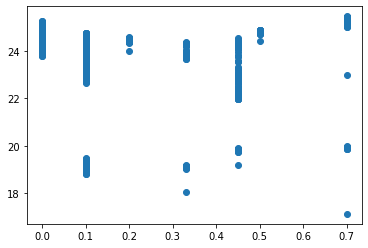

In [16]:
plt.scatter(ift_data['Water_content'],ift_data['IFT']);

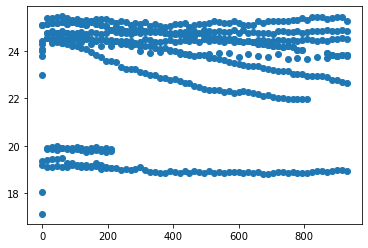

In [18]:
plt.scatter(ift_data['time_minutes'],ift_data['IFT']);

In [30]:
alt.Chart(ift_data, title = 'Change in IFT with water content over time for CH4 and CO2').mark_circle(size=60).encode(
    alt.X('time_minutes:Q', title = 'Time'),
    alt.Y('IFT:Q'),
    alt.Color('Gas:N'),
).interactive()

alt.Chart(...)

### Modeling

In [35]:
x= ift_data.iloc[:,:3] # get x
y = ift_data.iloc[:,4] # get y
# splitting the data into train and test model
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=123, shuffle=True)
# since we have numeric and categorical features we will create a column transformer to transform them seperately

# first transformer for the numeric features
numeric_features = ['Water_content', 'time_minutes']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])
# now a taransformer for the categorical features
categorical_features = ['Gas']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
# creating a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

ridge_model = Ridge()
# include the preprocessor and the model in one pipeline.
# Now we have a full prediction pipeline.
reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('Regressor', ridge_model)])

# finally we will pass the pipe line to gridsearchcv to find the optimum paramters for the model
param_grid = {
    'Regressor__alpha':[0.1,0.25,0.4],
}
search = GridSearchCV(reg_pipeline,param_grid,cv = 5)

# fitting the model
search.fit(X_train, y_train)

# printing the first parameter
print(search.best_params_)
print("model score: %.3f" % search.score(X_test, y_test))


{'Regressor__alpha': 0.4}
model score: 0.515


In [36]:
# let's look at he model paramters
model_intercept = search.best_estimator_['Regressor'].intercept_
model_intercept

22.6419145110395

In [37]:
model_slopes = search.best_estimator_['Regressor'].coef_
model_slopes


array([-0.28426813, -0.15528172,  1.68815898, -1.68815898])

In [38]:
coeff_parameter = pd.DataFrame(search.best_estimator_['Regressor'].coef_,columns=['Coefficient'])
coeff_parameter

,Coefficient
0,-0.284268
1,-0.155282
2,1.688159
3,-1.688159


In [39]:
# let's evaluate the model peroformance using MSE and MAE

In [40]:
y_pred = search.predict(X_test)

In [41]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 1.0916569015462978
Mean Squared Error: 2.092540826080975
Root Mean Squared Error: 1.4465617256380645


### Model Selection : Trying Gradient boosting

In [42]:
gb_model = GradientBoostingRegressor()
reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('Regressor', gb_model)])
param_grid = {
    'Regressor__learning_rate':[0.1,0.25,0.4],
}
search = GridSearchCV(reg_pipeline, param_grid, n_jobs=-1)

search.fit(X_train, y_train)
search.best_params_
print("model score: %.3f" % search.score(X_test, y_test))
#reg.get_params().keys()

model score: 0.997


In [43]:
y_pred = search.predict(X_test)

In [44]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))


Mean Absolute Error: 0.0727714656053726
Mean Squared Error: 0.01216619498468291
Root Mean Squared Error: 0.11030047590415423


In [45]:
X_test

,Gas,Water_content,time_minutes
466,CO2,0.10,195.0
157,CH4,0.20,555.0
452,CO2,0.00,930.0
449,CO2,0.00,885.0
467,CO2,0.10,210.0
...,...,...,...
508,CO2,0.10,825.0
374,CH4,0.70,615.0
181,CH4,0.20,915.0
485,CO2,0.10,480.0


In [46]:
y_test

466    19.12
157    24.38
452    23.80
449    23.81
467    19.09
       ...  
508    18.91
374    25.08
181    24.54
485    18.91
200    23.85
Name: IFT, Length: 113, dtype: float64

In [47]:
new_data = X_test.iloc[[0]]
new_data

,Gas,Water_content,time_minutes
466,CO2,0.1,195.0


In [48]:
search.predict(new_data)

array([19.1559994])

In [49]:
new_data.iloc[0,1] = 0.7

/Users/mosal/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [50]:
new_data


,Gas,Water_content,time_minutes
466,CO2,0.7,195.0


In [51]:
search.predict(new_data)

array([19.93307007])

In [52]:
## saving thee model : 

In [53]:
from joblib import dump, load


dump(search.best_estimator_, 'model.pkl')

['model.pkl']

In [54]:
model = load('model.pkl')

model.predict(new_data)

array([19.93307007])